<center>
  <h1> CS 6220 DATA MINING TECHNIQUES</h1>
  <h1> PROJECT SOURCE CODE </h1>
  <h1> FOOD BORNE ILLNESS ANALYSIS </h1>
</center>

<center>
  <h3> SRIJIT RAVISHANKAR </h3>
  <h3> SURUPA TUSHAR CHATTERJEE </h3>
</center>

In [1]:
# importing necessary packages for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.linear_model as sk
import seaborn as sns
import re
from sklearn import linear_model
import math
from sklearn.model_selection import train_test_split
from sklearn import svm
import sklearn.tree as tree
import sklearn.ensemble as en
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing as skp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import roc_curve, auc, classification_report
import scipy
from sklearn.metrics import confusion_matrix

In [2]:
# loading the food borne illness outbreaks dataset
data = pd.read_csv("outbreaks.csv")
data

,Year,Month,State,Location,Food,Ingredient,Species,Serotype/Genotype,Status,Illnesses,Hospitalizations,Fatalities
0,1998,January,California,Restaurant,NaN,NaN,NaN,NaN,NaN,20,0.0,0.0
1,1998,January,California,NaN,Custard,NaN,NaN,NaN,NaN,112,0.0,0.0
2,1998,January,California,Restaurant,NaN,NaN,NaN,NaN,NaN,35,0.0,0.0
3,1998,January,California,Restaurant,"Fish, Ahi",NaN,Scombroid toxin,NaN,Confirmed,4,0.0,0.0
4,1998,January,California,Private Home/Residence,"Lasagna, Unspecified; Eggs, Other",NaN,Salmonella enterica,Enteritidis,Confirmed,26,3.0,0.0
5,1998,January,California,Restaurant,NaN,NaN,Shigella boydii,NaN,Confirmed,25,3.0,0.0
6,1998,January,California,Restaurant,NaN,NaN,NaN,NaN,NaN,8,0.0,0.0
7,1998,January,California,Restaurant,"Stuffing, Unspecified; Sandwich, Turkey",NaN,Salmonella enterica,Enteritidis,Confirmed,4,3.0,0.0
8,1998,January,Colorado,Restaurant,"Salad, Unspecified",NaN,Virus,NaN,Suspected,21,NaN,NaN
9,1998,January,Colorado,Restaurant,"Peppers, Chili",NaN,Virus,NaN,Suspected,3,NaN,0.0


In [3]:
# Method to explode a string into list of values and add it to the dataset
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [4]:
# Method to clean the data by replacing the nulls 
# Nulls in numerical columns are replaced with mean of their respective columns
# Nulls in categorical columns are replaced with mode of their respective columns
def cleanData(data):
    for col in data.columns:
        if(data[col].dtype == 'object'):
            print("Replacing NaNs in ", col, " with mode")
            data[col] = data[col].fillna(data[col].value_counts().index[0])
        else:
            print("Replacing NaNs in ", col, " with mean")
            data[col] = data[col].fillna(data[col].mean())
    return data

In [5]:
# calling the clean data method to replace the nulls in data
cleanedData = cleanData(data)

Replacing NaNs in  Year  with mean
Replacing NaNs in  Month  with mode
Replacing NaNs in  State  with mode
Replacing NaNs in  Location  with mode
Replacing NaNs in  Food  with mode
Replacing NaNs in  Ingredient  with mode
Replacing NaNs in  Species  with mode
Replacing NaNs in  Serotype/Genotype  with mode
Replacing NaNs in  Status  with mode
Replacing NaNs in  Illnesses  with mean
Replacing NaNs in  Hospitalizations  with mean
Replacing NaNs in  Fatalities  with mean


In [6]:
# checking to see if there are any nulls left after cleaning
cleanedData.isna().any()

Year                 False
Month                False
State                False
Location             False
Food                 False
Ingredient           False
Species              False
Serotype/Genotype    False
Status               False
Illnesses            False
Hospitalizations     False
Fatalities           False
dtype: bool

In [7]:
# cleaning data further by exploding a string value in columns into list of values and adding to data
cleanedData = explode(cleanedData.assign(Location=cleanedData['Location'].str.split(";|,")), 'Location')
cleanedData = explode(cleanedData.assign(Food=cleanedData['Food'].str.split(";|,")), 'Food')
cleanedData = explode(cleanedData.assign(Ingredient=cleanedData['Ingredient'].str.split(";|,")), 'Ingredient')
cleanedData = explode(cleanedData.assign(Species=cleanedData['Species'].str.split(";|,")), 'Species')
cleanedData = explode(cleanedData.assign(SerotypeGenotype=cleanedData['Serotype/Genotype'].str.split(";|,")), 'SerotypeGenotype')
cleanedData = explode(cleanedData.assign(Status=cleanedData['Status'].str.split(";|,")), 'Status')
cleanedData = cleanedData.drop(columns = ['Serotype/Genotype'])

In [8]:
# stripping any spaces after cleaning
cleanedData = cleanedData.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [9]:
# checking the distribution of values across each column
for col in cleanedData.columns:
    if(cleanedData[col].dtype == 'object'):
        print(cleanedData.groupby(col).size())

Month
April          3618
August       141808
December       3435
February       2805
January        2824
July           3933
June           4307
March          3358
May            4192
November       3180
October        2858
September      3061
dtype: int64
State
Alabama                 449
Alaska                  164
Arizona                 452
Arkansas                614
California             5244
Colorado               1286
Connecticut             416
Delaware                 21
Florida                5208
Georgia                 721
Guam                     49
Hawaii                  798
Idaho                   207
Illinois               2271
Indiana                 202
Iowa                    378
Kansas                  508
Kentucky                137
Louisiana               186
Maine                   247
Maryland               1499
Massachusetts           527
Michigan               1831
Minnesota            139692
Mississippi             141
Missouri                358
Montana

In [10]:
# Checking the distribution of the dependent variable - "Status"
cleanedData.groupby('Status').size()

Status
Confirmed    83947
Suspected    95432
dtype: int64

In [11]:
# Storing this cleaned data for further use
cleanedData.to_excel("cleanedOutbreaks.xlsx")

In [12]:
# factorizing the categorical columns
for col in cleanedData.columns:
    if(cleanedData[col].dtype == 'object'):
        cleanedData[col] = pd.factorize(cleanedData[col])[0]
cleanedData

,Year,Month,State,Location,Food,Ingredient,Species,Status,Illnesses,Hospitalizations,Fatalities,SerotypeGenotype
0,1998,0,0,0,0,0,0,0,20,0.000000,0.000000,0
1,1998,0,0,0,1,0,0,0,112,0.000000,0.000000,0
2,1998,0,0,0,0,0,0,0,35,0.000000,0.000000,0
3,1998,0,0,0,2,0,1,0,4,0.000000,0.000000,0
4,1998,0,0,0,3,0,1,0,4,0.000000,0.000000,0
5,1998,0,0,1,4,0,2,0,26,3.000000,0.000000,1
6,1998,0,0,1,5,0,2,0,26,3.000000,0.000000,1
7,1998,0,0,1,6,0,2,0,26,3.000000,0.000000,1
8,1998,0,0,1,7,0,2,0,26,3.000000,0.000000,1
9,1998,0,0,0,0,0,3,0,25,3.000000,0.000000,0


In [13]:
# displaying the correlation matrix of the features in the dataset
cleanedData.corr()

,Year,Month,State,Location,Food,Ingredient,Species,Status,Illnesses,Hospitalizations,Fatalities,SerotypeGenotype
Year,1.000000,0.272561,-0.061344,0.770462,0.072109,0.370909,-0.112033,0.225823,0.588354,0.461114,-0.049804,0.391231
Month,0.272561,1.000000,-0.046620,0.352540,-0.002564,0.166240,-0.120186,0.105304,0.270343,0.211946,-0.021599,0.155902
State,-0.061344,-0.046620,1.000000,-0.166230,0.004856,-0.098580,0.115275,-0.140376,-0.103262,-0.124650,0.005658,-0.072211
Location,0.770462,0.352540,-0.166230,1.000000,-0.022356,0.417202,-0.309985,0.276143,0.720466,0.541135,-0.058428,0.416515
Food,0.072109,-0.002564,0.004856,-0.022356,1.000000,0.003961,0.100146,-0.013439,0.019833,0.079253,0.016345,0.006363
Ingredient,0.370909,0.166240,-0.098580,0.417202,0.003961,1.000000,-0.139813,0.133860,0.323164,0.262296,-0.025043,0.195173
Species,-0.112033,-0.120186,0.115275,-0.309985,0.100146,-0.139813,1.000000,-0.051985,-0.278114,-0.223148,0.061960,-0.141332
Status,0.225823,0.105304,-0.140376,0.276143,-0.013439,0.133860,-0.051985,1.000000,0.201294,0.148229,-0.028353,0.117372
Illnesses,0.588354,0.270343,-0.103262,0.720466,0.019833,0.323164,-0.278114,0.201294,1.000000,0.723728,-0.001986,0.342232
Hospitalizations,0.461114,0.211946,-0.124650,0.541135,0.079253,0.262296,-0.223148,0.148229,0.723728,1.000000,0.110722,0.277048


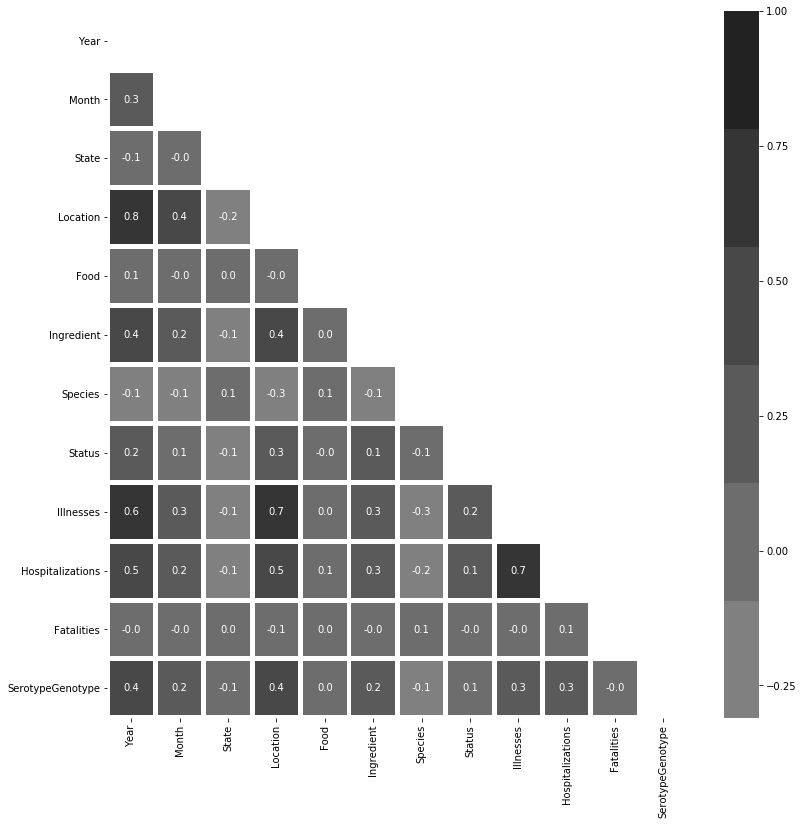

In [14]:
# plotting the correlation matrix for the features in the dataset
mask = np.zeros_like(cleanedData.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.dark_palette("grey", reverse=True)
f,ax=plt.subplots(figsize=(13,13))
sns.heatmap(cleanedData.corr(),mask=mask,cmap=cmap, annot=True,fmt='0.1f',linewidths=4,ax=ax)
plt.show()

# PREDICTING THE STATUS OF FOOD BORNE ILLNESS AS A CONFIRMED/ SUSPECTED CASE OF ILLNESS

In [15]:
# Separating the predictor and target variables to aid in building models accordingly
X = cleanedData.loc[:, cleanedData.columns != 'Status']
y = cleanedData.loc[:, 'Status']

In [16]:
# Splitting Data into Training and Testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)

### BASELINE MODELS

In [17]:
# function to print a given model's metrics
def modelfit(alg, dtrain, dy, dtest, dytest):
    #Fit the algorithm on the data
    alg.fit(dtrain, dy)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtest)
    dtrain_predprob = alg.predict_proba(dtest)[:,1]
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dytest, dtrain_predictions))
    print("AUC Score: %f" % roc_auc_score(dytest, dtrain_predprob))    
    
    pred = alg.predict(dtest)
    print(classification_report(dytest, pred))
    #print(confusion_matrix(dytest, pred))
    

### K-Nearest Neighbours

In [18]:
# Baseline model 1 - K-Nearest Neighbours with Default parameters
model = KNeighborsClassifier()
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Accuracy : 0.5975
AUC Score: 0.645335
              precision    recall  f1-score   support

           0       0.57      0.56      0.57     16796
           1       0.62      0.63      0.62     19080

   micro avg       0.60      0.60      0.60     35876
   macro avg       0.60      0.60      0.60     35876
weighted avg       0.60      0.60      0.60     35876



### Logistic Regression

In [19]:
# Baseline model 2 - Logisitic regression with default parameters
model = sk.LogisticRegression()
modelfit(model, Xtrain, ytrain, Xtest, ytest)

C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Model Report
Accuracy : 0.6396
AUC Score: 0.624351
              precision    recall  f1-score   support

           0       0.76      0.34      0.47     16796
           1       0.61      0.90      0.73     19080

   micro avg       0.64      0.64      0.64     35876
   macro avg       0.68      0.62      0.60     35876
weighted avg       0.68      0.64      0.61     35876



### AdaBoost

In [20]:
# Baseline model 4 - Adaboost with Default parameters
model = en.AdaBoostClassifier()
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Accuracy : 0.6638
AUC Score: 0.656718
              precision    recall  f1-score   support

           0       0.84      0.35      0.49     16796
           1       0.62      0.94      0.75     19080

   micro avg       0.66      0.66      0.66     35876
   macro avg       0.73      0.64      0.62     35876
weighted avg       0.72      0.66      0.63     35876



### Random Forest

In [21]:
# Baseline model 5 - RandomForest with Default parameters
model = en.RandomForestClassifier()
modelfit(model, Xtrain, ytrain, Xtest, ytest)

C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Model Report
Accuracy : 0.6856
AUC Score: 0.666997
              precision    recall  f1-score   support

           0       0.92      0.36      0.52     16796
           1       0.63      0.97      0.77     19080

   micro avg       0.69      0.69      0.69     35876
   macro avg       0.78      0.67      0.64     35876
weighted avg       0.77      0.69      0.65     35876



### Gradient Boosting Classifier

In [22]:
# Baseline model 6 - Gradient boosting with Default parameters
model = en.GradientBoostingClassifier()
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Accuracy : 0.67
AUC Score: 0.666600
              precision    recall  f1-score   support

           0       0.85      0.36      0.50     16796
           1       0.63      0.95      0.75     19080

   micro avg       0.67      0.67      0.67     35876
   macro avg       0.74      0.65      0.63     35876
weighted avg       0.73      0.67      0.64     35876



## From this, we can see that, out of all the baseline model, Random forest classifier performs the best and it is taken further for Hyper-parameter tuning and optimization

### Optimizing the model hyper parameters

In [23]:
# Optimising n_estimators for Random Forest classifier
p_test1 = {'n_estimators':[5,10,15,20]}

tuning = GridSearchCV(estimator =en.RandomForestClassifier(random_state=10), 
            param_grid = p_test1, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain,np.array(ytrain).ravel())
tuning.cv_results_ , tuning.best_params_, tuning.best_score_

C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\

({'mean_fit_time': array([1.58089347, 3.15887527, 4.33742919, 4.89949245]),
  'std_fit_time': array([0.09819282, 0.27423895, 0.37896282, 0.64857171]),
  'mean_score_time': array([0.09694023, 0.13165684, 0.2042345 , 0.21591291]),
  'std_score_time': array([0.01269914, 0.01430301, 0.02141737, 0.0658627 ]),
  'param_n_estimators': masked_array(data=[5, 10, 15, 20],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 5},
   {'n_estimators': 10},
   {'n_estimators': 15},
   {'n_estimators': 20}],
  'split0_test_score': array([0.67821058, 0.68030102, 0.68141593, 0.68169466]),
  'split1_test_score': array([0.67718895, 0.67889621, 0.67927947, 0.67886136]),
  'split2_test_score': array([0.68059233, 0.68233449, 0.68376307, 0.68369338]),
  'split3_test_score': array([0.67909408, 0.68080139, 0.68174216, 0.68209059]),
  'split4_test_score': array([0.68271777, 0.68498258, 0.68662021, 0.68679443]),
  'mean_test_score': 

In [24]:
# Optimising max_depth for Random Forest classifier
p_test2 = {'max_depth':[20,25,30,35,40,45] }
tuning = GridSearchCV(estimator =en.RandomForestClassifier(n_estimators=20, random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain,np.array(ytrain).ravel())
tuning.cv_results_ , tuning.best_params_, tuning.best_score_

C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\

({'mean_fit_time': array([5.79161124, 5.77257905, 5.7064425 , 5.21060786, 5.33327532,
         4.16759505]),
  'std_fit_time': array([0.07952303, 0.17921537, 0.05702955, 0.22151348, 0.10415183,
         1.19430257]),
  'mean_score_time': array([0.25911026, 0.22862921, 0.26140661, 0.27066059, 0.24924736,
         0.18300347]),
  'std_score_time': array([0.01994988, 0.03933664, 0.04252097, 0.09244502, 0.01887192,
         0.03581841]),
  'param_max_depth': masked_array(data=[20, 25, 30, 35, 40, 45],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 20},
   {'max_depth': 25},
   {'max_depth': 30},
   {'max_depth': 35},
   {'max_depth': 40},
   {'max_depth': 45}],
  'split0_test_score': array([0.6811372 , 0.68141593, 0.68071911, 0.68186886, 0.68155529,
         0.68169466]),
  'split1_test_score': array([0.67917494, 0.68025504, 0.67896589, 0.67931431, 0.67886136,
         0.67886136]),
  'split2_

Accuracy of the GBM on test set: 0.686
AUC Score: 0.667248
              precision    recall  f1-score   support

           0       0.93      0.36      0.52     16796
           1       0.63      0.98      0.77     19080

   micro avg       0.69      0.69      0.69     35876
   macro avg       0.78      0.67      0.64     35876
weighted avg       0.77      0.69      0.65     35876



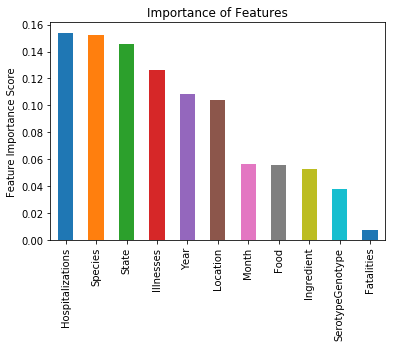

In [25]:
# checking performance of RandomForest with optimized parameters and plotting the feature importance plot.
model = en.RandomForestClassifier(n_estimators=20, max_depth=25)
model.fit(Xtrain,ytrain)
predictors=list(Xtrain)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model.score(Xtest, ytest)))
print("AUC Score: %f" % roc_auc_score(ytest, model.predict_proba(Xtest)[:,1]))
pred=model.predict(Xtest)
print(classification_report(ytest, pred))


In [26]:
# Optimising min_samples_split and min_samples_leaf for Random Forest classifier
p_test4 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}
tuning = GridSearchCV(estimator =en.RandomForestClassifier(n_estimators=20, max_depth=25, random_state=10), 
            param_grid = p_test4, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain,np.array(ytrain).ravel())
tuning.cv_results_ , tuning.best_params_, tuning.best_score_

C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\

({'mean_fit_time': array([5.83299742, 5.55368361, 5.32996759, 5.36352234, 5.05935731,
         5.45536237, 4.82994533, 5.11798563, 6.17253833, 4.56185045,
         4.58914456, 4.42563763, 4.78894486, 4.56106162, 4.23977928,
         3.48896012, 3.52137265, 3.54132671, 3.27464018, 3.39452395,
         3.49166551, 3.15915074, 3.37337675, 3.43461518, 3.07417793,
         3.24871297, 3.78459749, 3.8546174 , 3.9318316 , 3.99397168,
         3.69322429, 4.12037482, 3.72063632, 3.69253936, 4.99729075,
         4.23830862, 3.97060709, 3.60457273, 3.55731497, 3.98050108,
         3.58015671, 3.86117415, 3.84911323, 3.45030208, 3.65792823]),
  'std_fit_time': array([0.0617546 , 0.08226389, 0.05887116, 0.0453109 , 0.13860407,
         0.09257032, 0.29126418, 0.40417007, 0.79012474, 0.17126621,
         0.09909149, 0.187255  , 0.34532313, 0.44361589, 0.55719004,
         0.12305038, 0.19131132, 0.15824525, 0.10262043, 0.17422729,
         0.15259876, 0.12731482, 0.19376969, 0.17148109, 0.09287198,

Accuracy of the RF on test set: 0.687
AUC Score: 0.665191
              precision    recall  f1-score   support

           0       0.93      0.36      0.52     16796
           1       0.63      0.98      0.77     19080

   micro avg       0.69      0.69      0.69     35876
   macro avg       0.78      0.67      0.64     35876
weighted avg       0.77      0.69      0.65     35876

Confusion Matrix 
[[ 6025 10771]
 [  471 18609]]


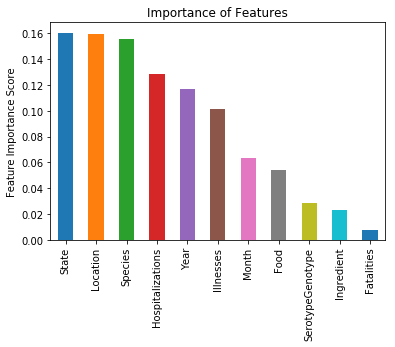

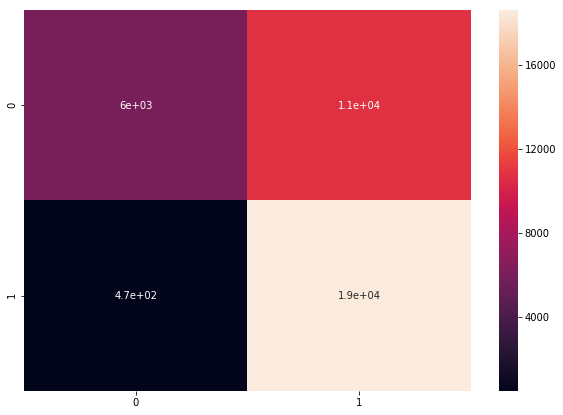

In [27]:
# checking performance of RandomForest with optimized parameters and plotting the feature importance plot
model = en.RandomForestClassifier(n_estimators=20, max_depth=25, min_samples_leaf=1, min_samples_split= 2, random_state=10)
model.fit(Xtrain,ytrain)
predictors=list(Xtrain)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the RF on test set: {:.3f}'.format(model.score(Xtest, ytest)))
print("AUC Score: %f" % roc_auc_score(ytest, model.predict_proba(Xtest)[:,1]))
pred=model.predict(Xtest)
print(classification_report(ytest, pred))
cm = confusion_matrix(ytest,pred)
#print('Confusion Matrix ')
#print(cm)
#plt.figure(figsize = (10,7))
#sn.heatmap(cm, annot=True)

# PREDICTING THE NUMBER OF ILLNESSES

In [28]:
data = pd.read_csv("cleanedOutbreaks.csv")
data

,Unnamed: 0,Year,Month,State,Location,Food,Ingredient,Species,Status,Illnesses,Hospitalizations,Fatalities,SerotypeGenotype
0,0,1998,0,0,0,0,0,0,0,20,0.000000,0.000000,0
1,1,1998,0,0,0,1,0,0,0,112,0.000000,0.000000,0
2,2,1998,0,0,0,0,0,0,0,35,0.000000,0.000000,0
3,3,1998,0,0,0,2,0,1,0,4,0.000000,0.000000,0
4,4,1998,0,0,0,3,0,1,0,4,0.000000,0.000000,0
5,5,1998,0,0,1,4,0,2,0,26,3.000000,0.000000,1
6,6,1998,0,0,1,5,0,2,0,26,3.000000,0.000000,1
7,7,1998,0,0,1,6,0,2,0,26,3.000000,0.000000,1
8,8,1998,0,0,1,7,0,2,0,26,3.000000,0.000000,1
9,9,1998,0,0,0,0,0,3,0,25,3.000000,0.000000,0


In [29]:
# Separating the predictor and target variables to aid in building models accordingly
X = data.loc[:, data.columns != 'Illnesses']
y = data.loc[:, 'Illnesses']

In [30]:
# Splitting Data into Training and Testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
# function to print a given model's metrics
def modelfit(alg, dtrain, dy, dtest, dytest):
    #Fit the algorithm on the data
    alg.fit(dtrain, dy)
    
    #Print model report:
    print("\nModel Report")
    print("Train Accuracy : %.4g" % alg.score(dtrain, dy))
    print("Test Accuracy : %.4g" % alg.score(dtest, dytest))

## BASELINE MODELS FOR PREDICTING ILLNESSES

### Linear Regression

In [32]:
# Baseline model - 1 : Linear Regression with default parameters
model = sk.LinearRegression()
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Train Accuracy : 0.6856
Test Accuracy : 0.6619


### Ridge Regression

In [33]:
# Baseline model - 2 : Ridge Regression with default parameters
ridge = sk.Ridge()
modelfit(ridge, Xtrain, ytrain, Xtest, ytest)


Model Report
Train Accuracy : 0.6856
Test Accuracy : 0.6619


### Decision Tree Regressor

In [34]:
# Baseline model - 3 : Decision Tree Regressor with default parameters
dct = tree.DecisionTreeRegressor()
modelfit(dct, Xtrain, ytrain, Xtest, ytest)


Model Report
Train Accuracy : 1
Test Accuracy : 0.8042


### Gradient Boosting Regressor

In [35]:
# Baseline model - 4 : Gradient boosting Regressor with default parameters
gbm = en.GradientBoostingRegressor()
modelfit(gbm, Xtrain, ytrain, Xtest, ytest)


Model Report
Train Accuracy : 0.8254
Test Accuracy : 0.7831


### Random Forest Regressor

In [36]:
# Baseline model - 5 : Random Forest Regressor with default parameters
rfmodel = en.RandomForestRegressor()
modelfit(rfmodel, Xtrain, ytrain, Xtest, ytest)

C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Model Report
Train Accuracy : 0.9838
Test Accuracy : 0.8324


### Optimizing the model hyper parameters

In [37]:
# Optimising n_estimators for Random Forest regressor using GridSearchCV
p_test1 = {'n_estimators':[20,50,80,100,120,150]}

tuning = GridSearchCV(estimator =en.RandomForestRegressor(random_state=10), 
            param_grid = p_test1, scoring='r2',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain,np.array(ytrain).ravel())
tuning.cv_results_, tuning.best_params_, tuning.best_score_

C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\

({'mean_fit_time': array([ 23.77119064,  46.27830472,  76.30244079, 100.58317595,
         122.87646852, 128.28861995]),
  'std_fit_time': array([ 2.47278568,  3.09742052,  1.6832845 ,  6.35614894,  3.5462111 ,
         13.1789102 ]),
  'mean_score_time': array([0.16911359, 0.39708595, 0.71498637, 0.81289582, 1.03177433,
         0.83931117]),
  'std_score_time': array([0.02032504, 0.0857803 , 0.18875097, 0.15001265, 0.19256522,
         0.24693223]),
  'param_n_estimators': masked_array(data=[20, 50, 80, 100, 120, 150],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 50},
   {'n_estimators': 80},
   {'n_estimators': 100},
   {'n_estimators': 120},
   {'n_estimators': 150}],
  'split0_test_score': array([0.91724447, 0.92301332, 0.92296807, 0.92278058, 0.92371374,
         0.92403247]),
  'split1_test_score': array([0.86734187, 0.87211223, 0.87353923, 0.87409595, 

In [38]:
# Checking performance of RandomForest with optimised parameters
model = en.RandomForestRegressor(n_estimators=120)
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Train Accuracy : 0.9885
Test Accuracy : 0.834


In [39]:
# Optimising min_samples_split and min_samples_leaf for Random Forest regressor using GridSearchCV
p_test4 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}

tuning = GridSearchCV(estimator =en.RandomForestRegressor(n_estimators=120,random_state=10), 
            param_grid = p_test4, scoring='r2',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain,np.array(ytrain).ravel())
tuning.cv_results_, tuning.best_params_, tuning.best_score_

C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SURUPA\Anaconda3\lib\site-packages\sklearn\

({'mean_fit_time': array([123.58868003, 137.0750298 , 125.20624318, 127.54513369,
         134.42710466, 124.52623973,  89.98506408, 115.34222283,
         111.12500653, 107.23927288, 107.50762281, 107.37135806,
         107.39120336, 106.54026189, 100.54964876,  86.02432346,
          78.07318721,  76.874193  ,  77.55278172,  77.92717671,
          76.89094591,  77.14567103,  77.63994422,  76.20637865,
         107.66089334, 111.79150634, 109.52214828, 129.84906535,
         110.6419095 ,  96.65931854,  79.77363725,  77.58668714,
          75.68437433,  74.3545311 ,  92.45119939,  85.14197054,
          81.69330182, 101.24772911, 119.49580903, 116.33809552,
         111.8596046 , 108.29272747, 109.64497814,  95.4664423 ,
          92.53011289]),
  'std_fit_time': array([13.04458006,  9.31485671,  5.36318803,  6.74132237,  3.62870004,
          8.84205716,  7.62032283, 18.97929861,  3.61492458,  3.17763917,
          3.15487981,  3.37854073,  3.67760661,  3.0058991 ,  1.69874452,
     

### Final optimised Random Forest Regressor model and its Performance

In [40]:
# Checking performance of RandomForest with optimised parameters
model = en.RandomForestRegressor(n_estimators=120, min_samples_split = 2, min_samples_leaf = 1)
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Train Accuracy : 0.9892
Test Accuracy : 0.8346
